# Segmentation of constructions elements

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D, Dropout, Add, Lambda
from tensorflow.keras import backend as K 
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras import utils 
from google.colab import files 
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing import image 
import numpy as np 
from sklearn.model_selection import train_test_split
import time
import random
import os 
from PIL import Image 

In [7]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Global parametrs
img_width = 176  
img_height = 240 
num_classes = 6 
directory = '/content/drive/My Drive/Сегментация/' #
train_directory = 'Тренировочная_стройка' ## Name of the folder with the training sample files
val_directory = 'Проверочная_стройка' # The name of the folder with the files of the val sample

In [8]:
train_images = [] # Create an empty list for storing the original images of the training sample
val_images = [] # Create an empty list to store the original images of the validation sample
test_images = [] # Create an empty list for storing the original images of the test sample

cur_time = time.time() 
for filename in sorted(os.listdir(directory + train_directory+'/Исходники')): # original images for train
    train_images.append(image.load_img(os.path.join(directory + train_directory+'/Исходники',filename),
                                       target_size=(img_width, img_height))) # Read the next image and add it to the image list with the specified target_size                                                      
print ('The training sample is loaded. Loading time: ', round(time.time() - cur_time, 2), 'sec', sep='') 
print ('Number of images: ', len(train_images)) 

cur_time = time.time() 
for filename in sorted(os.listdir(directory + val_directory+'/Исходники')):  # original images for val               
    val_images.append(image.load_img(os.path.join(directory + val_directory+'/Исходники',filename), 
                                     target_size=(img_width, img_height)))  # Read the next image and add it to the image list with the specified target_size
print ('The test sample is loaded. Loading time: ', round(time.time() - cur_time, 2), 'sec', sep='')
print ('Number of images: ', len(val_images))

The training sample is loaded. Loading time: 353.76sec
Number of images:  900
The test sample is loaded. Loading time: 19.47sec
Number of images:  50


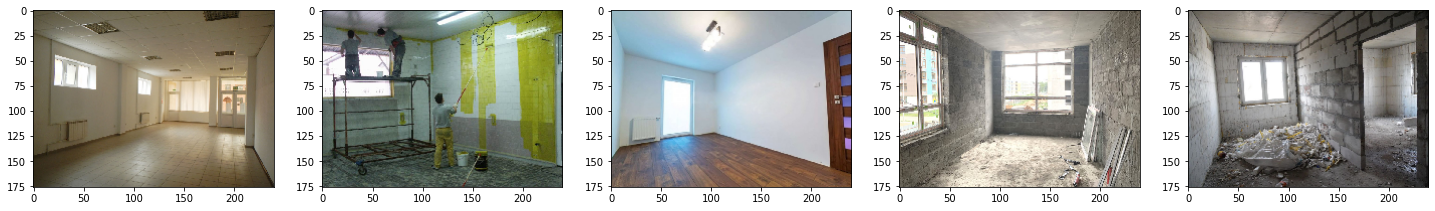

In [9]:
n = 5 # The number of displayed random images
fig, axs = plt.subplots(1, n, figsize=(25, 5)) 
for i in range(n): 
  img = random.choice(train_images) 
  axs[i].imshow(img) 
plt.show() 

In [10]:
train_segments = [] 
val_segments = [] 

cur_time = time.time() 
for filename in sorted(os.listdir(directory + train_directory+'/Размеченные')): #segmented/marked images for train
    train_segments.append(image.load_img(os.path.join(directory + train_directory+'/Размеченные',filename),
                                       target_size=(img_width, img_height)))                                       
print ('The training sample is loaded. Loading time: ', round(time.time() - cur_time, 2), 'sec', sep='') 
print ('Number of images: ', len(train_segments)) 

cur_time = time.time() 
for filename in sorted(os.listdir(directory + val_directory+'/Размеченные')):  #segmented/marked images for val
  val_segments.append(image.load_img(os.path.join(directory + val_directory+'/Размеченные',filename), 
                                     target_size=(img_width, img_height)))  
print ('The test sample is loaded. Loading time: ', round(time.time() - cur_time, 2), 'sec', sep='') 
print ('Number of images: ', len(val_segments)) 

The training sample is loaded. Loading time: 660.11sec
Number of images:  900
The test sample is loaded. Loading time: 32.79sec
Number of images:  50


### Sample

Floor

Outside the window

People

Heater

Light bulbs



In [11]:
# Function for converting a pixel of a segmented image to an index (6 classes)
def color2index(color):
  index=-1
  if (149>=color[0]>51)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=0 # floor
  elif (49>=color[0]>=0)and(49>=color[1]>=0)and(149>=color[2]>=51) : index=1 # outside the window
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(49>=color[2]>=0) : index=2 # people
  elif (149>=color[0]>=51)and(49>=color[1]>=0)and(49>=color[2]>=0) : index=4 # heater
  elif (49>=color[0]>=0)and(149>=color[1]>=51)and(149>=color[2]>=51) : index=3 # light bulbs
  else: index=5
  return index  

In [12]:
# Function to convert index to pixel color
def index2color(index2):
  index = np.argmax(index2) # Get the index of the maximum element
  color=[]
  if index == 0: color = [100, 100, 100]  # floor
  elif index == 1: color = [0, 0, 100]  #  outside the window
  elif index == 2: color = [0, 100, 0]  #people
  elif index == 3: color = [100, 0, 0]  # light bulbs
  elif index == 4: color = [0, 100, 100]  # heater
  elif index == 5: color = [0, 0, 0]  # other
  return color 

In [13]:
# Function for translating pixel index to to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy()
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Reshaping to a two-dimensional array
  yt = [] 
  for i in range(len(y)): 
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Convert pixels to indices and convert to OXE
  yt = np.array(yt) 
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Reshaping to original size
  return yt 

In [14]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Create an empty list for segmentation maps
  for seg in data: # Run through all files in the set with segmented images
    y = image.img_to_array(seg) 
    y = rgbToohe(y, num_classes) # Get the OHE representation of the generated array
    yTrain.append(y) 
    if len(yTrain) % 100 == 0: 
      print(len(yTrain)) 
  return np.array(yTrain) 

In [15]:
xTrain = [] 
for img in train_images: 
  x = image.img_to_array(img) 
  xTrain.append(x)
xTrain = np.array(xTrain) 

xVal = [] 
for img in val_images:
  x = image.img_to_array(img) 
  xVal.append(x) 
xVal = np.array(xVal) 

print(xTrain.shape) # The size of the training sample
print(xVal.shape) # The size of the validation sample

(900, 176, 240, 3)
(50, 176, 240, 3)


In [16]:
cur_time = time.time() 
yTrain = yt_prep(train_segments, num_classes)  
print('Time of processing: ', round(time.time() - cur_time, 2),'sec') 

100
200
300
400
500
600
700
800
900
Time of processing:  1057.45 sec


In [17]:
cur_time = time.time() 
yVal = yt_prep(val_segments, num_classes) 
print('Time of processing: ', round(time.time() - cur_time, 2),'sec') 

Time of processing:  55.11 sec


In [18]:
yTrain.shape

(900, 176, 240, 6)

In [19]:
# Function visualization of segmented images
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal), count) 
  fig, axs = plt.subplots(3, count, figsize=(25, 5)) 
  for i,idx in enumerate(indexes): 
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Predict the picture
    pr = predict[0] 
    pr1 = [] # an empty list for a segmented picture from predict
    pr2 = [] # an empty list for a segmented picture from yVal
    pr = pr.reshape(-1, n_classes) 
    yr = yVal[idx].reshape(-1, n_classes) 
    for k in range(len(pr)): # go through all levels (number of classes)
      pr1.append(index2color(pr[k])) 
      pr2.append(index2color(yr[k]))
    pr1 = np.array(pr1) 
    pr1 = pr1.reshape(img_width, img_height,3) # Reshape to image size
    pr2 = np.array(pr2) # into numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Reshape to image size
    img = Image.fromarray(pr1.astype('uint8')) # get an image from predict
    axs[0,i].imshow(img.convert('RGBA')) 
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Display on the graph in the second line the segmented image from yVal
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Display the original image on the chart in the third line       
  plt.show()  

In [23]:
'''
 Eigenfunction metric processing the intersection of two areas
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) #Return the area of intersection divided by the area of the union of the two areas

First, let's train the segmenting network on a linear network

In [24]:
'''
   Network creation function
     Input parameters:
     - num_classes - number of classes
     - input_shape - the size of the segmentation map
'''
def linearSegmentationNet(
      num_classes = 6,
      input_shape = (176, 240, 3)
      ):
    img_input = Input(input_shape)                                         
    x = Conv2D(128, (3, 3), padding='same', name='block1_conv1')(img_input) 
    x = BatchNormalization()(x)                                             
    x = Activation('relu')(x)                                               

    x = Conv2D(128, (3, 3), padding='same', name='block1_conv2')(x)         
    x = BatchNormalization()(x)                                             
    x = Activation('relu')(x)                                               

    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) 

    model = Model(img_input, x)                                             #

  
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model 

In [25]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) # Создаем моель linearSegmentationNet
modelL.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 176, 240, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 176, 240, 128)     3584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 176, 240, 128)     512       
_________________________________________________________________
activation_2 (Activation)    (None, 176, 240, 128)     0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 176, 240, 128)     147584    
_________________________________________________________________
batch_normalization_3 (Batch (None, 176, 240, 128)     512       
_________________________________________________________________
activation_3 (Activation)    (None, 176, 240, 128)     0   

In [26]:
modelL = linearSegmentationNet(num_classes, (img_width, img_height, 3)) # create a model linearSegmentationNet
history = modelL.fit(xTrain, yTrain, epochs=10, batch_size=32, validation_data=(xVal, yVal)) # training

Epoch 1/10
29/29 [==============================] - 23s 212ms/step - loss: 1.4321 - dice_coef: 0.3560 - val_loss: 5.2162 - val_dice_coef: 0.1715
Epoch 2/10
29/29 [==============================] - 5s 186ms/step - loss: 1.1732 - dice_coef: 0.4024 - val_loss: 4.6134 - val_dice_coef: 0.1742
Epoch 3/10
29/29 [==============================] - 5s 186ms/step - loss: 1.1557 - dice_coef: 0.4081 - val_loss: 2.6423 - val_dice_coef: 0.2044
Epoch 4/10
29/29 [==============================] - 5s 185ms/step - loss: 1.1520 - dice_coef: 0.4154 - val_loss: 2.5229 - val_dice_coef: 0.2106
Epoch 5/10
29/29 [==============================] - 5s 185ms/step - loss: 1.1565 - dice_coef: 0.4119 - val_loss: 1.6854 - val_dice_coef: 0.2741
Epoch 6/10
29/29 [==============================] - 5s 184ms/step - loss: 1.1299 - dice_coef: 0.4252 - val_loss: 1.5338 - val_dice_coef: 0.2845
Epoch 7/10
29/29 [==============================] - 5s 186ms/step - loss: 1.1163 - dice_coef: 0.4261 - val_loss: 1.4992 - val_dice_coef

## LinkNET
let's experiment with LinkNet architecture

In [27]:
'''
   Network creation function
     Input parameters:
     - num_classes - number of classes
     - input_shape - the size of the segmentation map
'''
def linkNet(
      num_classes = 6,
      input_shape = (176, 240, 3)
      ):
    img_input = Input(input_shape)                                          
    x = Conv2D(32, (3, 3), padding='same', name= "block1_conv1")(img_input)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same',name='block1_conv2')(x)

    block1_out = Activation('relu')(x)

    x = MaxPooling2D()(block1_out)

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)        
    x = BatchNormalization()(x)                                             
    x = Activation('relu')(x)    
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)         
    
    block2_out = Activation('relu')(x)
    x = MaxPooling2D()(block2_out)

    # UP 1 increase

    x = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(x)      # increase the dimension 2 times
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = Activation('relu')(x)

    x = Add()([x, block2_out])

    # UP 2 increase
    x = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(x)      # increase the dimension 2 times
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)

    x = Add()([x, block1_out])


    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) 

    model = Model(img_input, x)                                             

  
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model 

In [28]:
modelL_link = linkNet(num_classes, (img_width, img_height, 3)) # Create a model linkNet
modelL_link.summary()
history = modelL_link.fit(xTrain, yTrain, epochs=10, batch_size=32, validation_data=(xVal, yVal)) 

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
activation_6 (Activation)       (None, 176, 240, 32) 0           block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 176, 240, 32) 9248        activation_6[0][0]               
____________________________________________________________________________________________

Better results than linear network

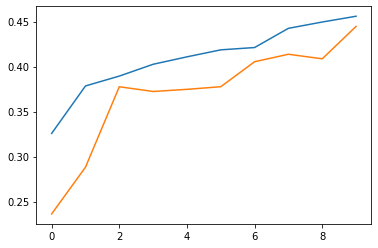

In [29]:
# visualize the model training graph
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

In [30]:
modelL_link.save_weights('/content/drive/My Drive/modelL_link.h5')

In [31]:
modelL_link = linkNet(num_classes, (img_width, img_height, 3))
modelL_link.load_weights('/content/drive/My Drive/modelL_link.h5')

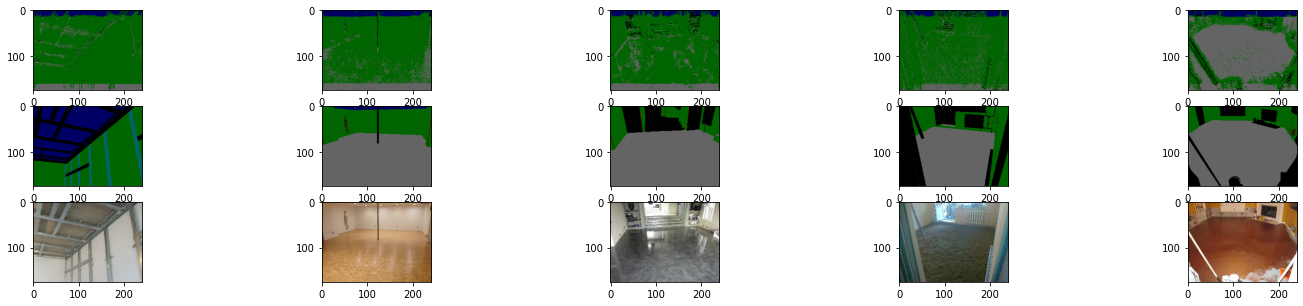

In [32]:
processImage(modelL_link, 5, num_classes)

## Experiment with different batch_size
Trying batch_size = 64

In [33]:
modelL_link_64 = linkNet(num_classes, (img_width, img_height, 3)) 
history =modelL_link_64.fit(xTrain, yTrain, epochs=10, batch_size=64, validation_data=(xVal, yVal))

Epoch 1/10
15/15 [==============================] - 7s 308ms/step - loss: 22.5899 - dice_coef: 0.2464 - val_loss: 3.0651 - val_dice_coef: 0.3675
Epoch 2/10
15/15 [==============================] - 4s 256ms/step - loss: 3.0814 - dice_coef: 0.4133 - val_loss: 2.6290 - val_dice_coef: 0.2847
Epoch 3/10
15/15 [==============================] - 4s 250ms/step - loss: 2.0545 - dice_coef: 0.3786 - val_loss: 1.9709 - val_dice_coef: 0.3168
Epoch 4/10
15/15 [==============================] - 4s 251ms/step - loss: 1.7404 - dice_coef: 0.3497 - val_loss: 1.7817 - val_dice_coef: 0.3149
Epoch 5/10
15/15 [==============================] - 4s 253ms/step - loss: 1.5837 - dice_coef: 0.3629 - val_loss: 1.6277 - val_dice_coef: 0.3683
Epoch 6/10
15/15 [==============================] - 4s 252ms/step - loss: 1.4343 - dice_coef: 0.3947 - val_loss: 1.5248 - val_dice_coef: 0.3642
Epoch 7/10
15/15 [==============================] - 4s 252ms/step - loss: 1.3906 - dice_coef: 0.3962 - val_loss: 1.5140 - val_dice_coef

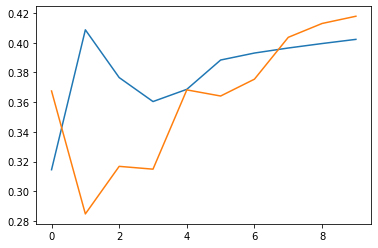

In [34]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

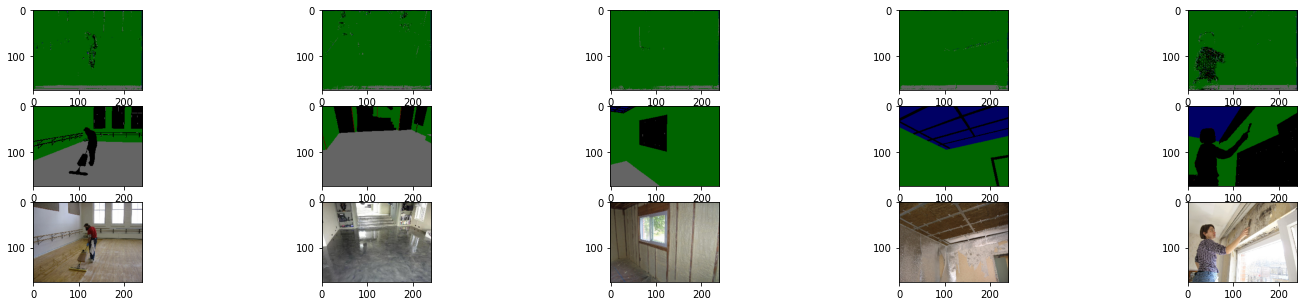

In [35]:
processImage(modelL_link_64, 5, num_classes)

trying batch_size = 16

In [36]:
modelL_link_16 = linkNet(num_classes, (img_width, img_height, 3)) 
history =modelL_link_16.fit(xTrain, yTrain, epochs=10, batch_size=16, validation_data=(xVal, yVal)) 

Epoch 1/10
57/57 [==============================] - 5s 76ms/step - loss: 6.8486 - dice_coef: 0.3620 - val_loss: 3.8269 - val_dice_coef: 0.2080
Epoch 2/10
57/57 [==============================] - 4s 71ms/step - loss: 1.7733 - dice_coef: 0.3911 - val_loss: 1.5423 - val_dice_coef: 0.4061
Epoch 3/10
57/57 [==============================] - 4s 71ms/step - loss: 1.4302 - dice_coef: 0.3948 - val_loss: 1.3211 - val_dice_coef: 0.4231
Epoch 4/10
57/57 [==============================] - 4s 71ms/step - loss: 1.2532 - dice_coef: 0.4105 - val_loss: 1.5665 - val_dice_coef: 0.4254
Epoch 5/10
57/57 [==============================] - 4s 71ms/step - loss: 1.1168 - dice_coef: 0.4471 - val_loss: 1.3881 - val_dice_coef: 0.4792
Epoch 6/10
57/57 [==============================] - 4s 72ms/step - loss: 1.0642 - dice_coef: 0.4666 - val_loss: 1.2825 - val_dice_coef: 0.4211
Epoch 7/10
57/57 [==============================] - 4s 71ms/step - loss: 1.0553 - dice_coef: 0.4519 - val_loss: 1.1693 - val_dice_coef: 0.4625

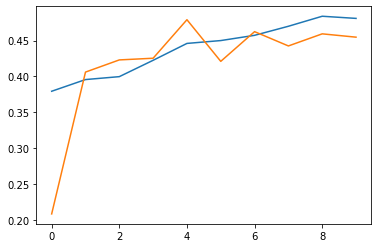

In [37]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

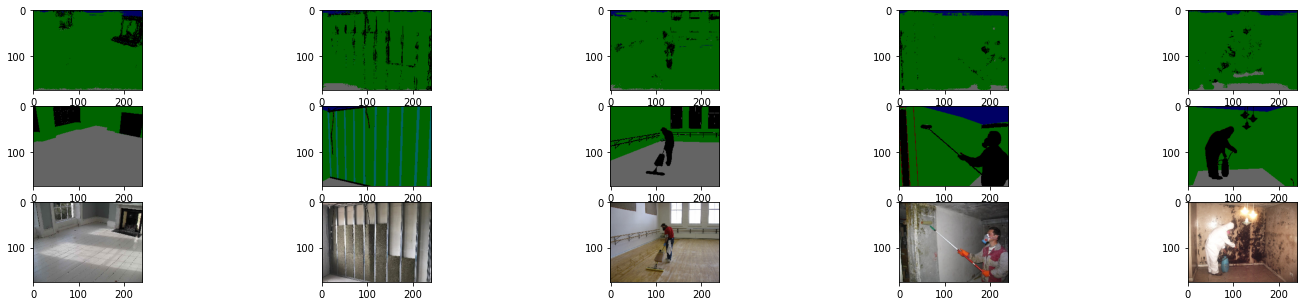

In [38]:
processImage(modelL_link_16, 5, num_classes)

## Experimenting with BatchNormalization
Since training on validation sample has jumps down and up, it was thought to add more BatchNormalization layers to net. 

In [39]:
'''
   Network creation function
     Input parameters:
     - num_classes - number of classes
     - input_shape - the size of the segmentation map
'''
def linkNet_2(
      num_classes = 6,
      input_shape = (176, 240, 3)
      ):
    img_input = Input(input_shape)                                          
    x = Conv2D(32, (3, 3), padding='same', name= "block1_conv1")(img_input)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same',name='block1_conv2')(x)
    x = BatchNormalization()(x) 

    block1_out = Activation('relu')(x)

    x = MaxPooling2D()(block1_out)

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)        
    x = BatchNormalization()(x)                                             
    x = Activation('relu')(x)    
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)  
    x = BatchNormalization()(x)        
    
    block2_out = Activation('relu')(x)
    x = MaxPooling2D()(block2_out)

    # UP 1 

    x = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(x)      # increase the dimension 2 times
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Add()([x, block2_out])

    # UP 2 
    x = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(x)       # increase the dimension 2 times
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Add()([x, block1_out])


    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) 

    model = Model(img_input, x)                                             


    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model 

In [40]:
modelL_link2 = linkNet_2(num_classes, (img_width, img_height, 3)) 
modelL_link2.summary()
history =modelL_link2.fit(xTrain, yTrain, epochs=10, batch_size=64, validation_data=(xVal, yVal))

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 32) 896         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 176, 240, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_46 (Activation)      (None, 176, 240, 32) 0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

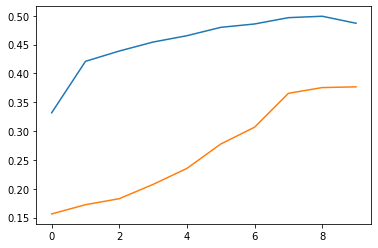

In [41]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

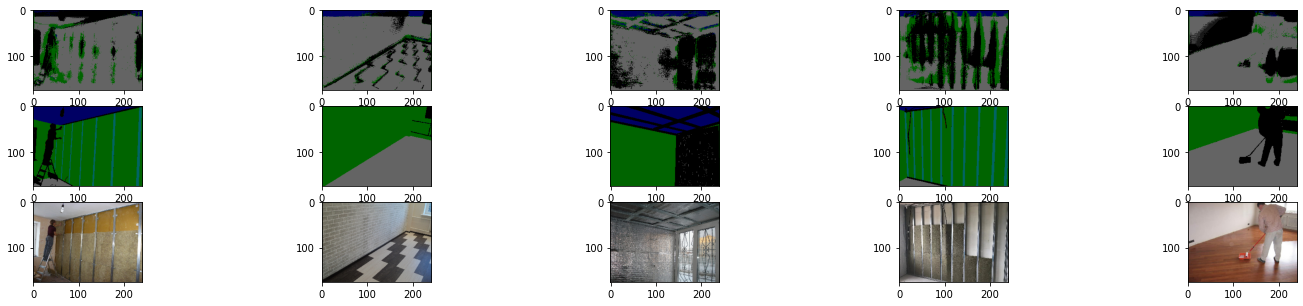

In [42]:
processImage(modelL_link2, 5, num_classes)

In [43]:
# additional training
history =modelL_link2.fit(xTrain, yTrain, epochs=20, batch_size=32, validation_data=(xVal, yVal))

Epoch 1/20
29/29 [==============================] - 5s 168ms/step - loss: 0.9594 - dice_coef: 0.5035 - val_loss: 1.2844 - val_dice_coef: 0.3643
Epoch 2/20
29/29 [==============================] - 5s 166ms/step - loss: 0.9365 - dice_coef: 0.5113 - val_loss: 1.0793 - val_dice_coef: 0.4134
Epoch 3/20
29/29 [==============================] - 5s 163ms/step - loss: 0.9256 - dice_coef: 0.5197 - val_loss: 0.9956 - val_dice_coef: 0.4563
Epoch 4/20
29/29 [==============================] - 5s 166ms/step - loss: 0.9015 - dice_coef: 0.5281 - val_loss: 1.1126 - val_dice_coef: 0.4315
Epoch 5/20
29/29 [==============================] - 5s 164ms/step - loss: 0.9135 - dice_coef: 0.5255 - val_loss: 1.0123 - val_dice_coef: 0.4895
Epoch 6/20
29/29 [==============================] - 5s 165ms/step - loss: 0.8914 - dice_coef: 0.5406 - val_loss: 1.1025 - val_dice_coef: 0.4324
Epoch 7/20
29/29 [==============================] - 5s 163ms/step - loss: 0.8901 - dice_coef: 0.5348 - val_loss: 1.0786 - val_dice_coef:

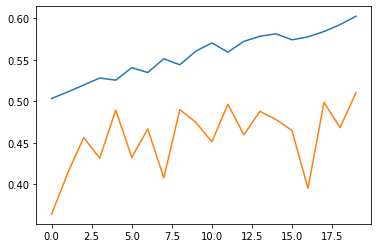

In [44]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

With BatchNormalization and more epochs, the results look slightly better.
The next stage is experiment with activations.

## Experiments with activations

In [46]:
'''
  switch relu on selu
'''
def linkNet_3(
      num_classes = 6,
      input_shape = (176, 240, 3)
      ):
    img_input = Input(input_shape)                                          
    x = Conv2D(32, (3, 3), padding='same', name= "block1_conv1")(img_input)
    x = BatchNormalization()(x) 
    x = Activation('selu')(x)
    x = Conv2D(32, (3, 3), padding='same',name='block1_conv2')(x)
    #x = BatchNormalization()(x) 

    block1_out = Activation('selu')(x)

    x = MaxPooling2D()(block1_out)

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)        
    x = BatchNormalization()(x)                                             
    x = Activation('selu')(x)    
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)  
    #x = BatchNormalization()(x)        
    
    block2_out = Activation('selu')(x)
    x = MaxPooling2D()(block2_out)

    # UP 1 

    x = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(x)      
    x = BatchNormalization()(x) 
    x = Activation('selu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x) 
    x = Activation('selu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x) 
    x = Activation('selu')(x)

    x = Add()([x, block2_out])

    # UP 2

    x = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(x)      
    x = BatchNormalization()(x) 
    x = Activation('selu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x) 
    x = Activation('selu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x) 
    x = Activation('selu')(x)

    x = Add()([x, block1_out])


    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model

In [47]:
modelL_link3 = linkNet_3(num_classes, (img_width, img_height, 3)) 
history =modelL_link3.fit(xTrain, yTrain, epochs=10, batch_size=64, validation_data=(xVal, yVal))

Epoch 1/10
15/15 [==============================] - 6s 311ms/step - loss: 2.0250 - dice_coef: 0.2340 - val_loss: 5.8540 - val_dice_coef: 0.1707
Epoch 2/10
15/15 [==============================] - 4s 288ms/step - loss: 1.3075 - dice_coef: 0.3882 - val_loss: 4.8682 - val_dice_coef: 0.1674
Epoch 3/10
15/15 [==============================] - 4s 293ms/step - loss: 1.2486 - dice_coef: 0.3836 - val_loss: 2.8561 - val_dice_coef: 0.1984
Epoch 4/10
15/15 [==============================] - 4s 291ms/step - loss: 1.1955 - dice_coef: 0.3993 - val_loss: 2.3539 - val_dice_coef: 0.2183
Epoch 5/10
15/15 [==============================] - 4s 290ms/step - loss: 1.1732 - dice_coef: 0.3997 - val_loss: 1.8861 - val_dice_coef: 0.2682
Epoch 6/10
15/15 [==============================] - 4s 296ms/step - loss: 1.1562 - dice_coef: 0.4096 - val_loss: 1.9152 - val_dice_coef: 0.2580
Epoch 7/10
15/15 [==============================] - 4s 292ms/step - loss: 1.1465 - dice_coef: 0.4134 - val_loss: 1.6274 - val_dice_coef:

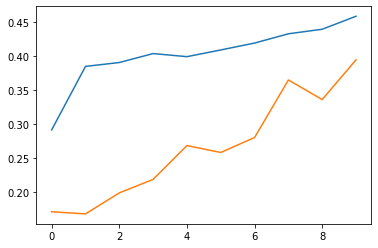

In [48]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

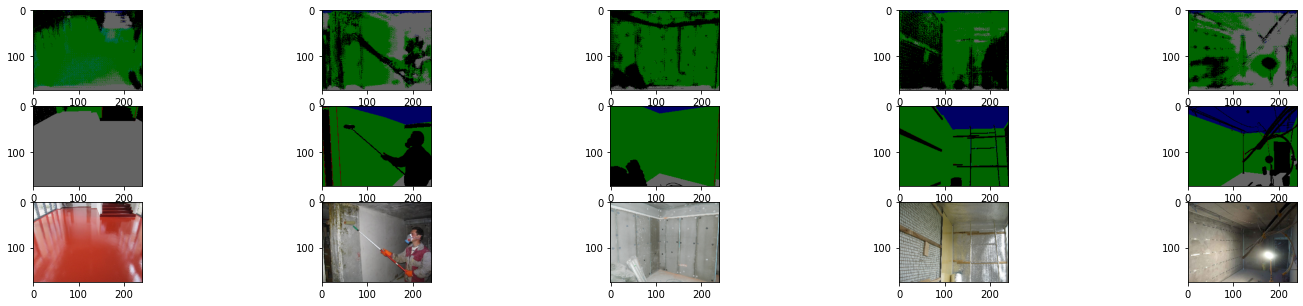

In [49]:
processImage(modelL_link3, 5, num_classes)

The second option

In [50]:
'''
  Switch relu on elu and tanh
'''
def linkNet_4(
      num_classes = 6,
      input_shape = (176, 240, 3)
      ):
    img_input = Input(input_shape)                                          
    x = Conv2D(32, (3, 3), padding='same', name= "block1_conv1")(img_input)
    x = BatchNormalization()(x) 
    x = Activation('elu')(x)
    x = Conv2D(32, (3, 3), padding='same',name='block1_conv2')(x)
    #x = BatchNormalization()(x) 

    block1_out = Activation('tanh')(x)

    x = MaxPooling2D()(block1_out)

    x = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(x)         
    x = BatchNormalization()(x)                                             
    x = Activation('elu')(x)    
    x = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(x)  
    #x = BatchNormalization()(x)        
    
    block2_out = Activation('tanh')(x)
    x = MaxPooling2D()(block2_out)

    # UP 1 

    x = Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(x)      
    x = BatchNormalization()(x) 
    x = Activation('elu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x) 
    x = Activation('elu')(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x) 
    x = Activation('tanh')(x)

    x = Add()([x, block2_out])

    # UP 2 

    x = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(x)     
    x = BatchNormalization()(x) 
    x = Activation('elu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x) 
    x = Activation('elu')(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    #x = BatchNormalization()(x) 
    x = Activation('tanh')(x)

    x = Add()([x, block1_out])


    x = Conv2D(num_classes,(3, 3), activation='softmax', padding='same')(x) 

    model = Model(img_input, x)                                             
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model 

In [51]:
modelL_link4 = linkNet_4(num_classes, (img_width, img_height, 3))
history =modelL_link4.fit(xTrain, yTrain, epochs=10, batch_size=64, validation_data=(xVal, yVal)) 

Epoch 1/10
15/15 [==============================] - 6s 309ms/step - loss: 1.6147 - dice_coef: 0.2958 - val_loss: 1.5019 - val_dice_coef: 0.3063
Epoch 2/10
15/15 [==============================] - 4s 289ms/step - loss: 1.2026 - dice_coef: 0.3970 - val_loss: 1.5880 - val_dice_coef: 0.2774
Epoch 3/10
15/15 [==============================] - 4s 289ms/step - loss: 1.1563 - dice_coef: 0.4317 - val_loss: 1.9498 - val_dice_coef: 0.2177
Epoch 4/10
15/15 [==============================] - 4s 289ms/step - loss: 1.1247 - dice_coef: 0.4150 - val_loss: 1.4405 - val_dice_coef: 0.2778
Epoch 5/10
15/15 [==============================] - 4s 291ms/step - loss: 1.0942 - dice_coef: 0.4416 - val_loss: 1.9330 - val_dice_coef: 0.2286
Epoch 6/10
15/15 [==============================] - 4s 291ms/step - loss: 1.0758 - dice_coef: 0.4564 - val_loss: 1.2334 - val_dice_coef: 0.3552
Epoch 7/10
15/15 [==============================] - 4s 289ms/step - loss: 1.0304 - dice_coef: 0.4720 - val_loss: 1.5100 - val_dice_coef:

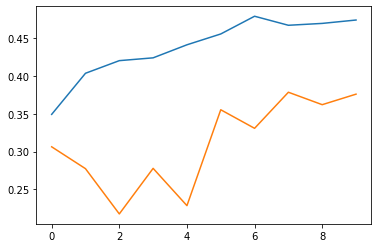

In [52]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

##Output:
relu is the most versatile activation function than elu, selu, tanh.
Increasing the batch size twice gave better results than the original (32) or reduced (16).
BatchNormalization (and Dropout) make the training schedule smoother, there are no sudden jumps up or down. However, the accuracy of the net decreases.

#  PSPNet for segmentation task



In [54]:
'''
  create a net
    input:
    - num_classes - number of classes
    - input_shape - size of the segmentation map
'''
def PSPNet(
      num_classes = 6,
      input_shape = (176, 240, 3)):
    img_input = Input(input_shape)                                          
    x = Conv2D(32, (3, 3), padding='same', name= "block1_conv1")(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same',name='block1_conv2')(x)
    x = Activation('relu')(x)
    
    # pooling pyramid is typical of this particular architecture

    block_1_out = MaxPooling2D((2,2))(x)
    block_2_out = MaxPooling2D((4,4))(x)
    block_3_out = MaxPooling2D((8,8))(x)
    block_4_out = MaxPooling2D((16,16))(x)
    
    # Convolutional layers 

    block_1_out = Conv2D(64, (3, 3), padding='same', name='block2_conv1')(block_1_out)  
    block_1_out = Activation('relu')(block_1_out)
    block_2_out = Conv2D(64, (3, 3), padding='same', name='block2_conv2')(block_2_out)  
    block_2_out = Activation('relu')(block_2_out)
    block_3_out = Conv2D(64, (3, 3), padding='same', name='block2_conv3')(block_3_out)  
    block_3_out = Activation('relu')(block_3_out)
    block_4_out = Conv2D(64, (3, 3), padding='same', name='block2_conv4')(block_4_out)  
    block_4_out = Activation('relu')(block_4_out)
    

    # UP 1 

    block_1_out = Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(block_1_out )     
    block_1_out = Activation('relu')(block_1_out)
   
    block_2_out = Conv2DTranspose(32,(4,4),strides=(4,4),padding='same')(block_2_out )     
    block_2_out = Activation('relu')(block_2_out)

    block_3_out = Conv2DTranspose(32,(8,8),strides=(8,8),padding='same')(block_3_out )     
    block_3_out = Activation('relu')(block_3_out)

    block_4_out = Conv2DTranspose(32,(16,16),strides=(16,16),padding='same')(block_4_out )     
    block_4_out = Activation('relu')(block_4_out)

    

    # to concatenate layers
    out = concatenate([block_1_out, block_2_out, block_3_out, block_4_out])
    out = Conv2D(32, (3, 3), padding='same', name= "block3_conv1")(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
   

   
    # output layer
    out=Conv2D(num_classes,(3,3),activation='softmax',padding= 'same')(out)
    
    model = Model(img_input, out)
    model.compile(optimizer=Adam(lr=1e-3),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    return model 

In [55]:
modelL_psp = PSPNet(num_classes, (img_width, img_height, 3)) 
modelL_psp.summary()
history =modelL_psp.fit(xTrain, yTrain, epochs=20, batch_size=32, validation_data=(xVal, yVal))

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 176, 240, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 176, 240, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 176, 240, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 176, 240, 32) 0           batch_normalization_28[0][0]     
___________________________________________________________________________________________

In [56]:
# additional training
history =modelL_psp.fit(xTrain, yTrain, epochs=8, batch_size=32, validation_data=(xVal, yVal)) 

Epoch 1/8
29/29 [==============================] - 5s 161ms/step - loss: 0.6279 - dice_coef: 0.6699 - val_loss: 1.0319 - val_dice_coef: 0.5641
Epoch 2/8
29/29 [==============================] - 5s 160ms/step - loss: 0.6330 - dice_coef: 0.6652 - val_loss: 0.9395 - val_dice_coef: 0.5860
Epoch 3/8
29/29 [==============================] - 5s 160ms/step - loss: 0.6403 - dice_coef: 0.6622 - val_loss: 0.9632 - val_dice_coef: 0.5772
Epoch 4/8
29/29 [==============================] - 5s 159ms/step - loss: 0.6363 - dice_coef: 0.6661 - val_loss: 1.0859 - val_dice_coef: 0.5391
Epoch 5/8
29/29 [==============================] - 5s 159ms/step - loss: 0.6102 - dice_coef: 0.6764 - val_loss: 0.9778 - val_dice_coef: 0.5888
Epoch 6/8
29/29 [==============================] - 5s 160ms/step - loss: 0.6091 - dice_coef: 0.6798 - val_loss: 1.2922 - val_dice_coef: 0.5165
Epoch 7/8
29/29 [==============================] - 5s 159ms/step - loss: 0.5986 - dice_coef: 0.6818 - val_loss: 1.0189 - val_dice_coef: 0.5742

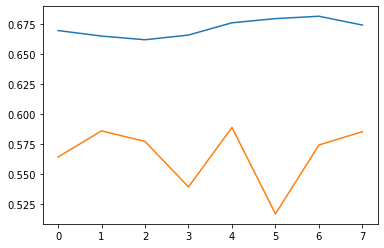

In [57]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.show()

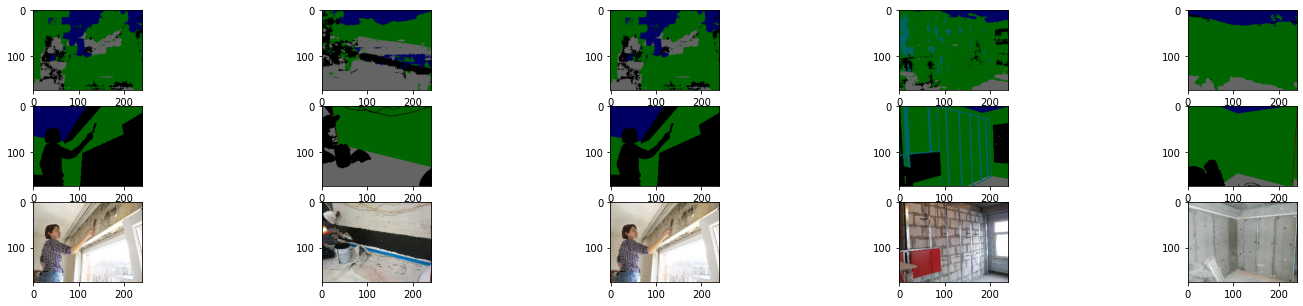

In [58]:
processImage(modelL_psp, 5, num_classes)